In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as T
from tqdm import tqdm
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from sever.data_loader import SteelDataLoader

In [3]:
NWORKERS = 8
DATA_DIR = Path('../data/raw/severstal-steel-defect-detection')
IMG_DIR  = DATA_DIR / 'train_images'
TEST_DIR = DATA_DIR / 'test_images'

In [4]:
train_imgs = list(IMG_DIR.glob('*.jpg'))
test_imgs = list(TEST_DIR.glob('*.jpg'))
print(len(train_imgs), len(test_imgs))

12568 1801


In [5]:
img = cv2.imread(str(train_imgs[0]))
img.shape

(256, 1600, 3)

In [8]:
a = torch.rand((256, 1600, 3))
a.mean(dim=[0, 1])

tensor([0.4998, 0.5000, 0.5001])

In [13]:
means = torch.zeros((3, len(train_imgs)))
means

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [14]:
def load(filename):
    x = cv2.imread(str(filename))
    return T.ToTensor()(x)

def mean(filename):
    t = load(filename)
    return t.mean(dim=[1, 2])

with ThreadPoolExecutor(max_workers=NWORKERS) as executor:
    results = {executor.submit(mean, str(f)): f for f in train_imgs}
    for future in tqdm(as_completed(results), total=len(train_imgs)):
        idx = train_imgs.index(results[future])
        means[:, idx] = future.result()

100%|██████████| 12568/12568 [01:09<00:00, 182.01it/s]


In [16]:
means = means.mean(dim=1)
means

tensor([0.3439, 0.3439, 0.3439])

In [26]:
def residuals(filename, means):
    t = load(filename)
    r0 = (t[0, :, :] - means[0])
    r1 = (t[1, :, :] - means[1])
    r2 = (t[2, :, :] - means[2])
    
    s0 = (r0 ** 2).mean()
    s1 = (r1 ** 2).mean()
    s2 = (r2 ** 2).mean()
    
    return torch.tensor([s0, s1, s2])

In [27]:
mean_residuals = torch.zeros((3, len(train_imgs)))
mean_residuals

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [29]:
with ThreadPoolExecutor(max_workers=NWORKERS) as executor:
    results = {executor.submit(residuals, str(f), means): f for f in train_imgs}
    for future in tqdm(as_completed(results), total=len(train_imgs)):
        idx = train_imgs.index(results[future])
        mean_residuals[:, idx] = future.result()

100%|██████████| 12568/12568 [01:30<00:00, 139.02it/s]


In [31]:
mean_residuals.mean(dim=1)

tensor([0.0383, 0.0383, 0.0383])

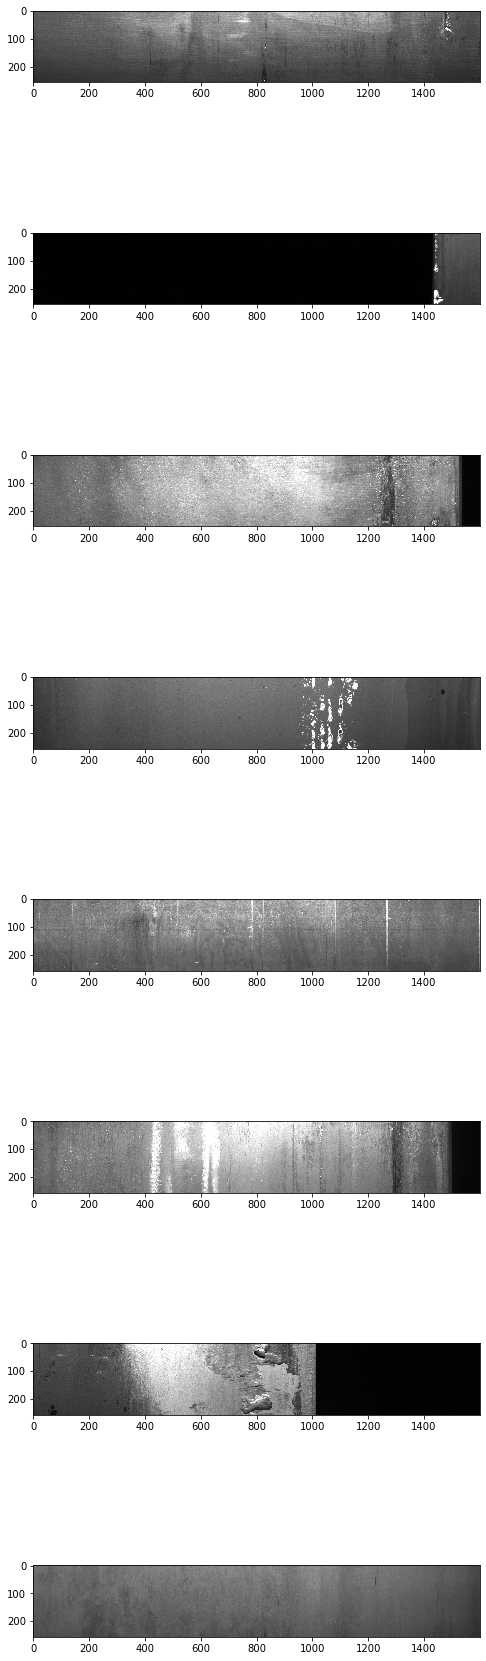

In [35]:
fig, axs = plt.subplots(8, 1, figsize=(8, 32))
np.random.shuffle(train_imgs)
for i, f in enumerate(train_imgs[:8]):
    img = cv2.imread(str(f))[::-1]
    axs[i].imshow(img)
plt.show()

In [44]:
def channels_same(f):
    img = cv2.imread(f)
    BG = (img[:, :, 0] == img[:, :, 1]).all()
    BR = (img[:, :, 0] == img[:, :, 2]).all()
    return BG or BR

In [45]:
count = 0
with ThreadPoolExecutor(max_workers=NWORKERS) as executor:
    results = {executor.submit(channels_same, str(f)): f for f in test_imgs}
    for future in tqdm(as_completed(results), total=len(test_imgs)):
        if future.result():
            count += 1
print(count)

100%|██████████| 1801/1801 [00:01<00:00, 1250.68it/s]

1801


In [36]:
for f in train_imgs[:20]:
    img = cv2.imread(str(f))
    BG = np.abs((img[:, :, 0] - img[:, :, 1])).mean()
    print(BG)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
